# Advanced Simulation Modeling

contact: annaszczurek2@gmail.com

## 04 RIG CASE STUDY - INVESTMENT

A group of SGH graduates, having investment advisor license, founded the RIG company and opened their own closed investment fund.
The fund's strategy assumes investing in a portfolio of shares from among 11 the most promising securities quoted on the WSE.

The goal is to maximize the rate of return over a 1 year horizon (252 session days) assuming that:

Option 1. The expected rate of return cannot be lower than 5%.

Option 2. The portfolio variance may not be higher than half the variance of returns on shares with the highest variance

## SOLUTION

### 1. MARKET DATA

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.optimize as so
import statsmodels.formula.api as sm


,1,2,3,4,5,6,7,8,9,10,11
count,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000
mean,3.150324,47.478610,182.236744,228.653350,15.611336,30.123116,18.892176,48.442129,47.236311,106.656304,2.778602
std,2.110382,36.207499,124.951682,328.249191,24.600025,52.890094,14.174137,41.688915,26.027696,69.136185,2.453910
min,0.730000,10.000000,63.100000,6.200000,0.980000,0.650000,5.200000,2.440000,15.200000,27.700000,0.620000
25%,1.490000,20.500000,104.000000,11.400000,2.200000,4.777500,8.900000,25.700000,26.200000,48.400000,1.080000
50%,2.480000,30.300000,130.000000,58.000000,3.800000,7.800000,13.800000,35.300000,40.950000,82.200000,1.710000
75%,4.550000,81.925000,201.000000,395.275000,20.000000,40.650000,24.925000,62.700000,67.262500,151.200000,3.860000
max,13.990000,143.000000,600.000000,1480.000000,124.500000,364.500000,80.000000,250.500000,178.900000,315.300000,12.450000


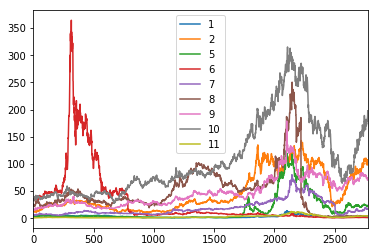

In [5]:
# read rig.txt data, describe, visualize
data = pd.read_csv("rig.txt", delimiter = ";", header = None, usecols=range(1,12))
data.drop([3,4], axis = 1).plot()
data.describe()

#### Returns

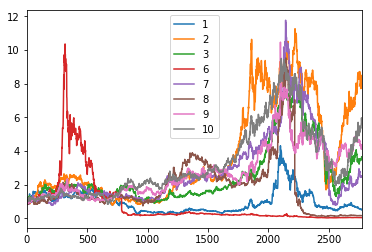

In [10]:
# calculate returns for each share - relative to the initial value
data_returns0 = data.apply(lambda x: x/x[0])
data_returns0.head(10)
data_returns0.drop([4, 5, 11], axis = 1).plot()

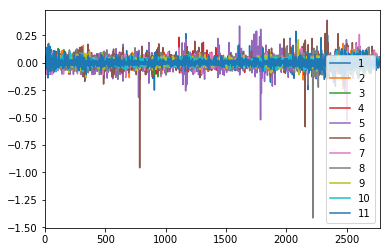

In [11]:
# calculate logaritmic daily returns
data_returns = data.apply(lambda x: np.log(x) - np.log(x.shift(1)))
data_returns.plot()

#### Market data - moving averages and MNK

In [12]:
# MV 50, 200 and 500

mv50 = data.rolling(window = 50, center = False).mean()
mv200 = data.rolling(window = 200, center = False).mean()
mv500 = data.rolling(window = 500, center = False).mean()


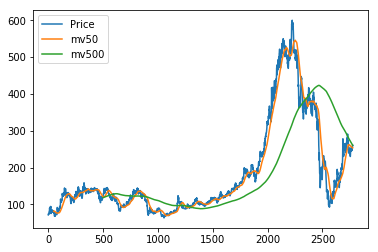

In [13]:
plt.plot(data[3], label = "Price")
plt.plot(mv50[3], label = "mv50")
plt.plot(mv500[3], label = "mv500")
plt.legend()
plt.show()

### 2. Select optimal portfolio for 2 scenarios
#### SCENARIO 1: expected rate of return >= 5%

expected rate of return should be at least 5%, using a geometric mean its daily value is calculated

In [14]:
# calculate daily expected rate of return using a geometric mean for 252 session days 
r_min = 1.05 ** (1/252) - 1; r_min

0.00019363050654397362

#### SCENARIO 2: portfolio variance - cannot be higher than half the variance of returns on shares with the highest variance

calculate average and standard deviation of the log returns for each share and based on the result set the portfolio variance limit

In [21]:
# calculate average and standard deviation of the log returns for each share
r_mean = data_returns.mean() 
r_std = data_returns.std()

# calculate maximum portfolio variance
var_max = 0.5 * ( max(r_std)**2 )
# var_max

0.0011293660940754839

#### Initial portfolio

- create covariance and correlation matrix based on RoR
- assign initial portfolio weights
- functions calculating return on investments and portfolio variance

(por. np. https://www.bankier.pl/wiadomosc/Dywersyfikacja-7337529.html)

In [17]:
# create covariance and correlation matrices for log returns 
cov = data_returns.cov()
cor = data_returns.corr()

# create initial shares weight - assuming each share is equally important
weights = np.ones(data.shape[1])/(data.shape[1]) ; weights

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

In [18]:
# create functions for calculating portfolio mean and variance (risk)

def portfolio_mean(weights):
    return( sum(weights * r_mean) )

def portfolio_var(weights):
    return( np.dot(np.dot(weights, cov), weights) )

print(portfolio_mean(weights))
print(portfolio_var(weights))

0.00029859226472953997
0.00027833832194213543


#### Optimization models for each scenario

[COBYLA](https://en.wikipedia.org/wiki/COBYLA) = Constrained optimization by linear approximation

type: inequality means that the constraint function result is to be non-negative

#### SCENARIO 1 - constraints

In [22]:
cons1 = ({'type':'ineq', 'fun': lambda w: sum(w) - 1},
        {'type':'ineq', 'fun': lambda w: portfolio_mean(w) - r_min})

# optimization model 1
opt_1 = so.minimize(portfolio_var, weights, method = "COBYLA", 
                    constraints = cons1)

# results
w_1 = opt_1.x
print(w_1); print(sum(w_1))
print( (1 + portfolio_mean(w_1)) ** 252 - 1 )
print( portfolio_var(w_1) )

[0.0043759  0.03538182 0.08480225 0.16566359 0.02818422 0.00852641
 0.15109213 0.0519963  0.2194652  0.11706152 0.13345066]
0.9999999999999993
0.1625708356085911
0.00022512420971109739


#### SCENARIO 2 - constraints

In [23]:
cons2 = ({'type':'ineq', 'fun': lambda w: sum(w) - 1},
        {'type':'ineq', 'fun': lambda w: var_max - portfolio_var(w)})

# model optymalizacyjny 1
opt_2 = so.minimize(portfolio_var, weights, method = "COBYLA", 
                    constraints = cons2)

# wyniki
w_2 = opt_2.x
print(w_2); print(sum(w_2))
print( (1 + portfolio_mean(w_2)) ** 252 - 1 )
print( portfolio_var(w_2) )

[0.00437148 0.03537207 0.08479935 0.16553235 0.02818377 0.00849803
 0.15102722 0.05204216 0.21947179 0.11720955 0.13349223]
0.9999999999999999
0.16254454393612616
0.00022512419319781107


### 3. SIMULATION MODEL AND `RUN()` FUNCTION


estimate financial result assuming optimized models


- [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition)
- [Jak losować zmienne ze złożonych rozkładów?](http://pbiecek.github.io/Przewodnik/Programowanie/generatory_3.html)

In [ ]:
def simulation (data, time_horizon, weights):
    
    # create a dataframe of daily log returns
    log_returns = 
    
    # calculate log_return average and standard deviation of each share
    std_r = 
    mean_r = 
    
    # based on a correlation matrix find the lower triangular matrix from Cholesky decomposition
    corr = log_returns.corr()
    L = np.linalg.cholesky(corr)
    
    # initial share values (most recent historical stock values):
    P0 = 
    
    # generate returns assuming a multidimensional normal distribution
    rates = []
    for i in range(time_horizon):
        # generate a list of random numbers N~(0,1) - one for each action
        random_vector = 
        
        # calculate the product of the random_vector and the transposed matrix L
        random_vector = 
        
        # append to the "rates" a list of generated random value ~N(0,1) multiplied by 
        # log_returns standard deviation and increased by the average value for each share
        
    
    r_cum = # cumulative sum of returns on shares
    r_cum = # exp (r_cum) for each action
    
    # V = (P0 * weights * r_cum ) # end value (P0 multiplied by r_cum)
    V = sum(P0 * weights * r_cum ) # end value (P0 multiplied by r_cum)
    
    return(V)


def run(repeats, data, time_horizon, weights):
    V = []    
    for i in range(repeats):
        V.append(simulation(data, time_horizon, weights))
    return(V)


### 3. SIMULATION RESULTS

#### SCENARIO 1

In [ ]:
start_value = sum(data.iloc[len(data) - 1] * w_1)

final_value = run(10, data, 252, w_1)

In [ ]:
final_value

## REPORT 

### Run simulations that will verify the fund's effectiveness in both assumed scenarios

**deadline: 05.05.2020 EOD**


### TODO

Interpret the simulation results and for each scenario:
1. Calculate an average portfolio value with its standard deviation.
2. Calculate maximum portfolio loss (VaR) in the horizon of one year (assume a confidence level of 99%).
3. Visualize detailed simulation results.